In [28]:
import capnp
import sys
import glob
import os
import numpy as np
sys.path.append('/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt')

%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
import CapnpGame_capnp

/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/games_combined/000093a8-ea03-405c-8140-b6b545639158


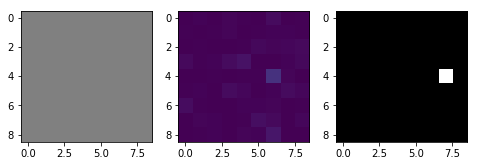

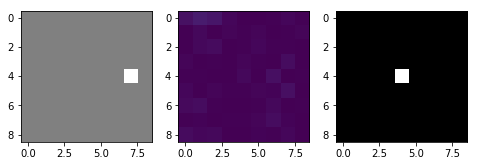

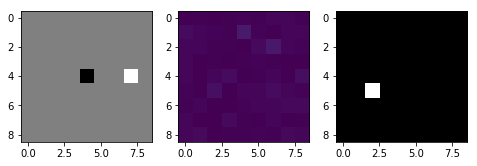

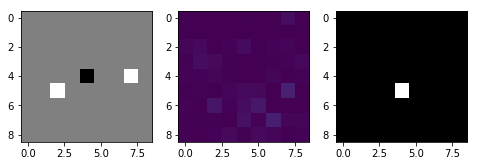

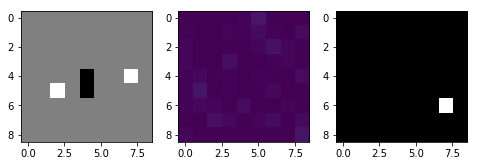

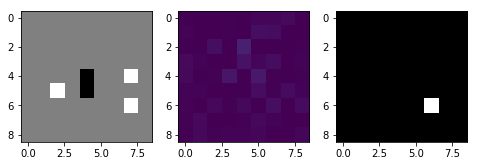

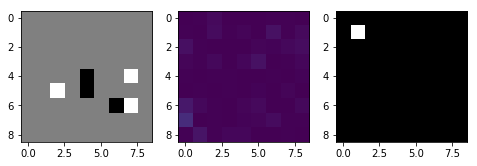

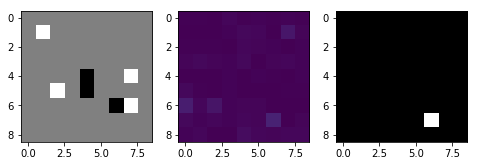

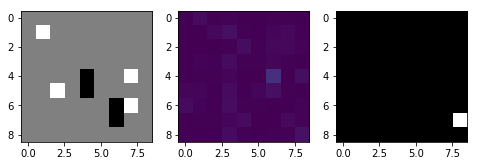

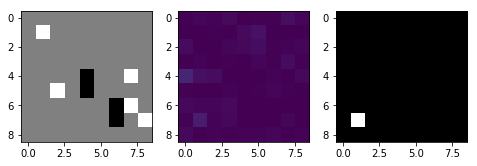

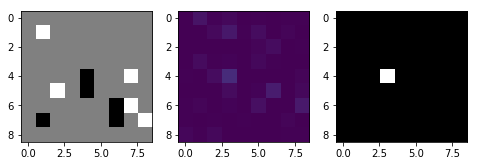

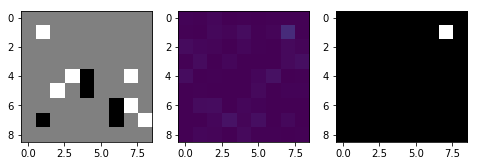

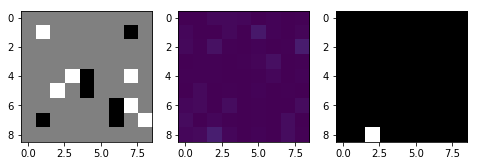

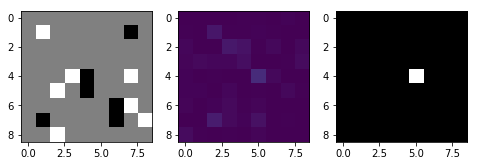

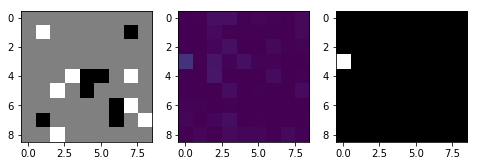

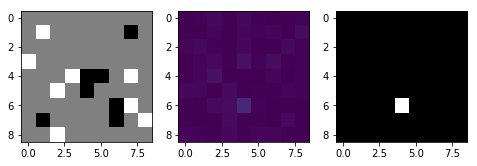

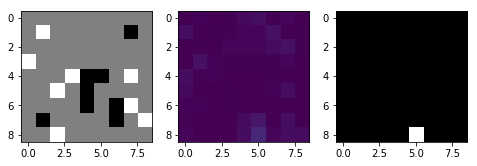

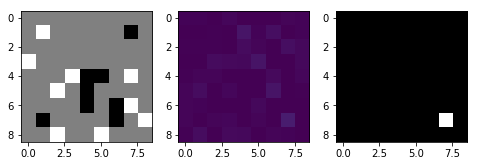

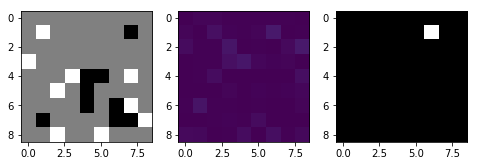

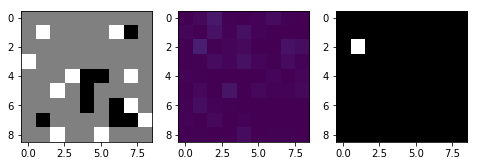

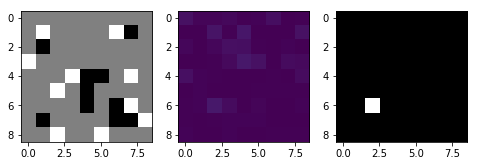

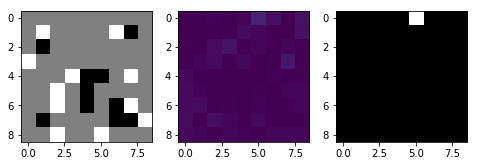

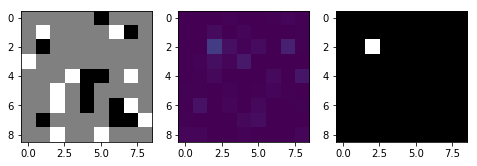

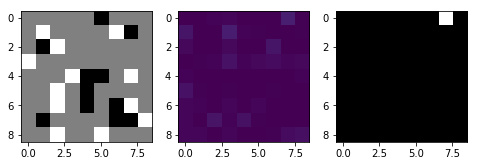

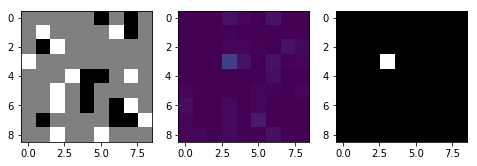

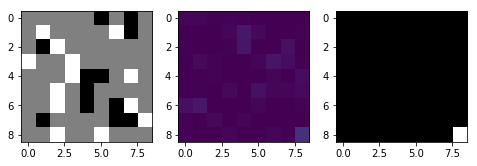

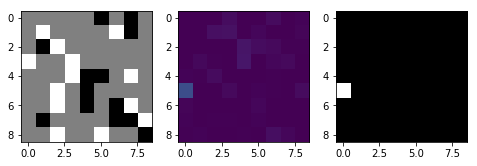

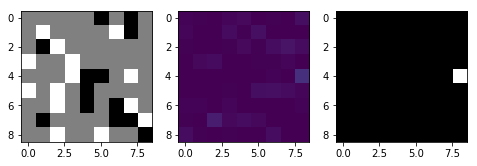

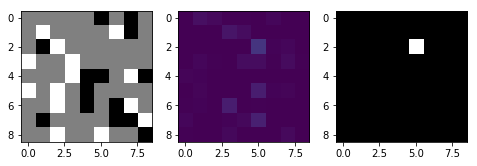

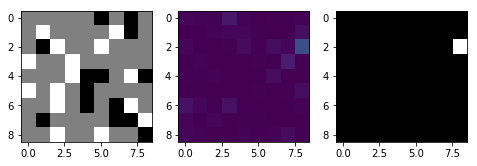

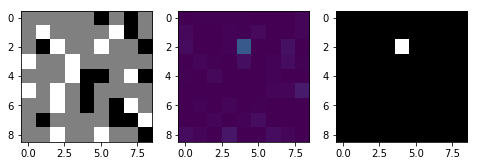

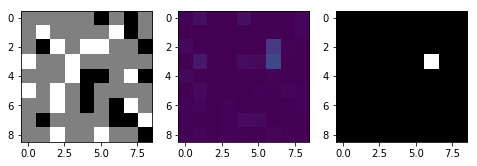

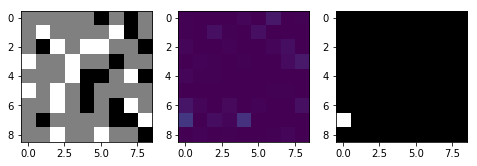

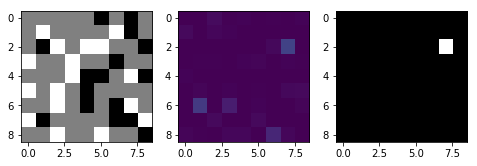

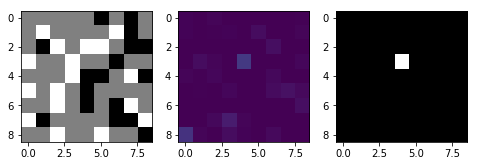

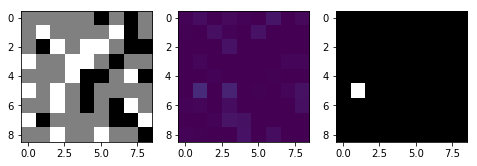

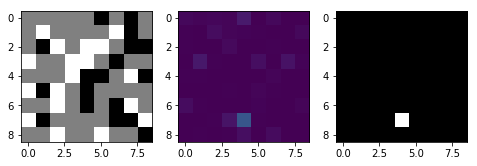

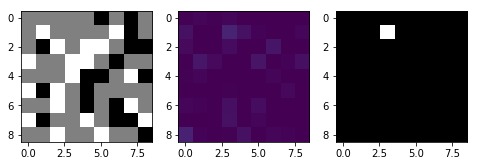

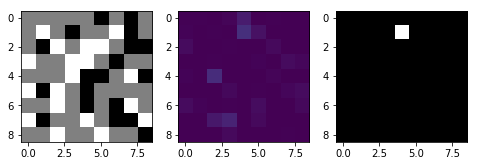

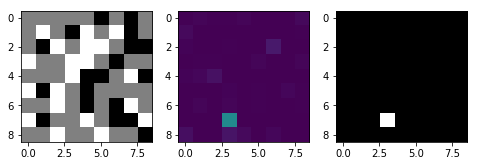

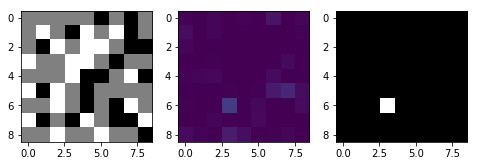

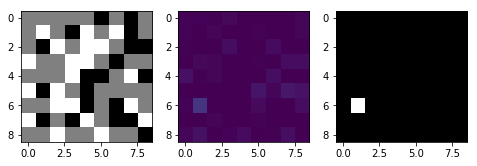

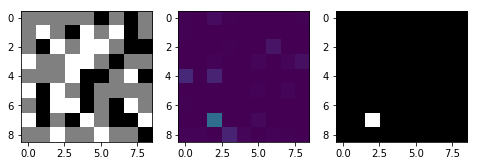

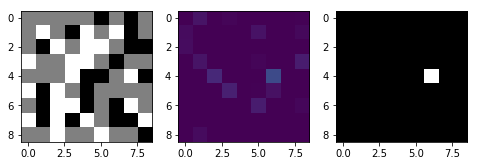

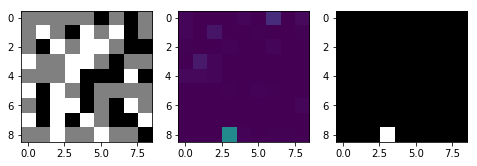

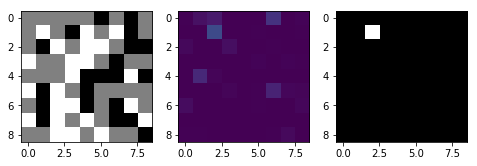

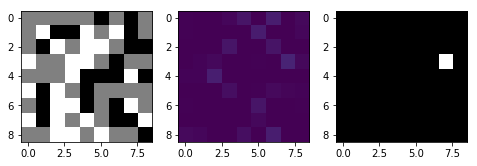

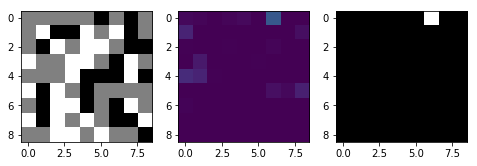

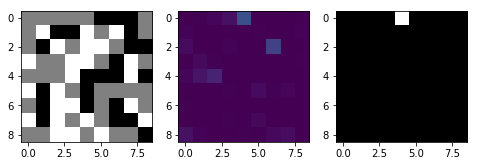

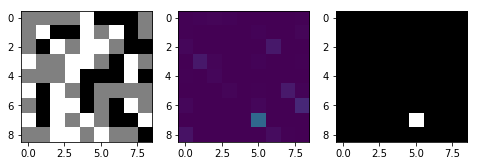

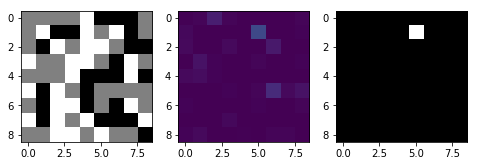

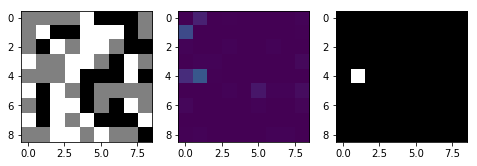

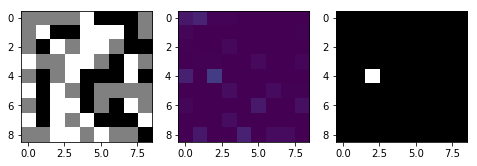

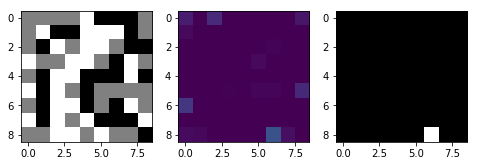

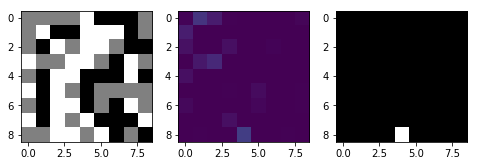

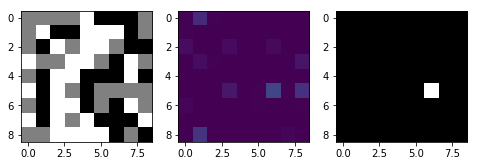

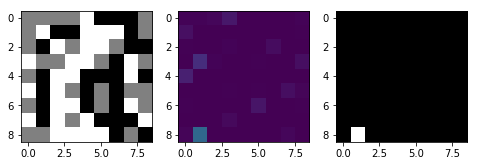

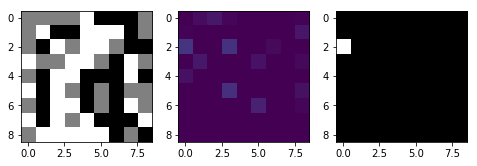

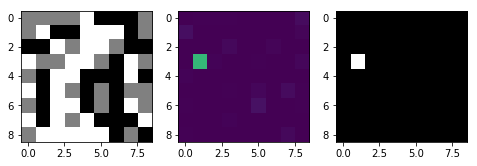

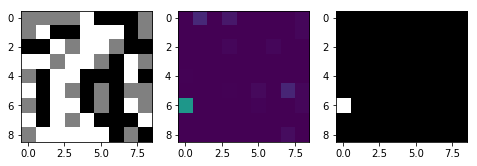

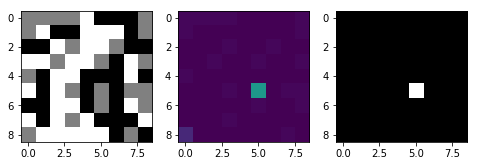

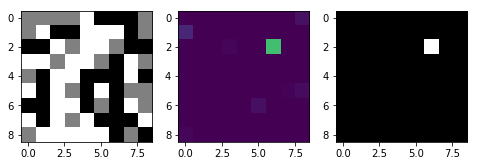

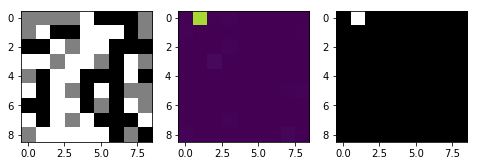

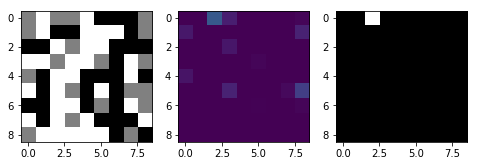

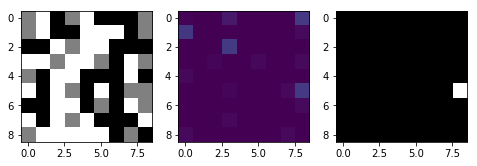

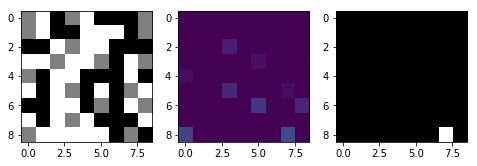

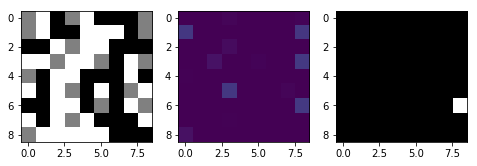

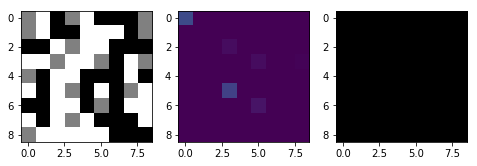

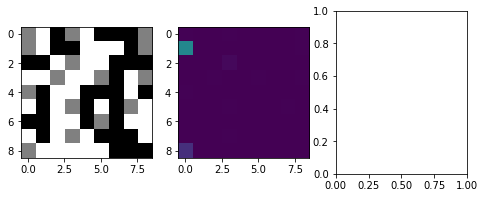

True


In [5]:

games_combined_path = '/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/games_combined/*'
for file in glob.glob(games_combined_path):
    print(file)
    f = open(file, 'rb')
    g = CapnpGame_capnp.Game.from_bytes_packed(f.read())
    
    for i in range(len(g.stateprobs)):
        b = np.array(g.stateprobs[i].state).reshape((4 + 8 , 9, 9))[0]
        w = np.array(g.stateprobs[i].state).reshape((4 + 8 , 9, 9))[1]
        s = b - w
        
        fig, axes = plt.subplots(1, 3, figsize=(8, 3))
        axes[0].imshow(s, cmap=plt.cm.gray, vmin=-1, vmax=1)    
        axes[1].imshow(np.array(g.stateprobs[i].probs)[:-1].reshape(9, 9), vmin=0, vmax=1)
        
        if i < len(g.stateprobs) - 1:
            b_n = np.array(g.stateprobs[i+1].state).reshape((4 + 8 , 9, 9))[0]
            w_n = np.array(g.stateprobs[i+1].state).reshape((4 + 8 , 9, 9))[1]
            s_n = b_n - w_n
            m_n = np.abs(s_n) - np.abs(s)
            m_n[m_n < 0] = 0
            
            axes[2].imshow(m_n, cmap=plt.cm.gray, vmin=0, vmax=1)    
        
        plt.show()
    
    print(g.result)
    
    break

In [6]:
len(glob.glob(games_combined_path))

17466

/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/games_combined/000093a8-ea03-405c-8140-b6b545639158


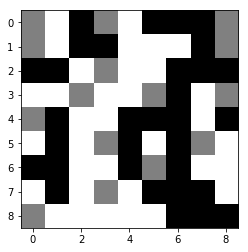

True


In [7]:
for file in glob.glob(games_combined_path):
    print(file)
    f = open(file, 'rb')
    g = CapnpGame_capnp.Game.from_bytes_packed(f.read())
    
    for i in range(len(g.stateprobs)):
        b = np.array(g.stateprobs[i].state).reshape((4 + 8 , 9, 9))[0]
        w = np.array(g.stateprobs[i].state).reshape((4 + 8 , 9, 9))[1]
        
    plt.imshow(b - w, cmap=plt.cm.gray)    
    plt.show()
    
    print(g.result)
    
    break

/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/games_combined/000093a8-ea03-405c-8140-b6b545639158
69 True


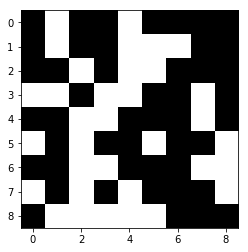

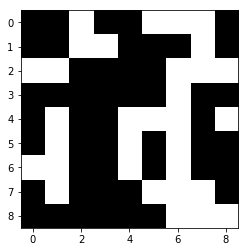

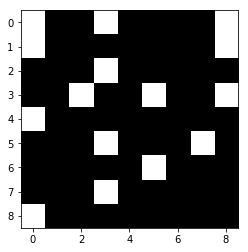

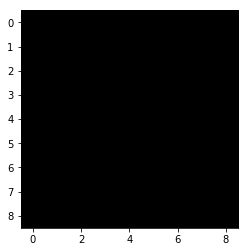

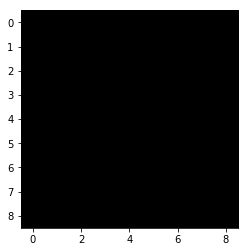

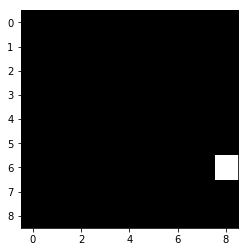

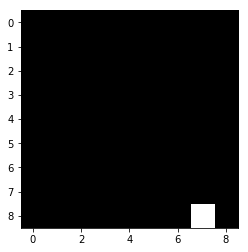

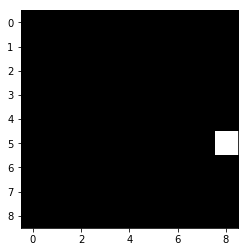

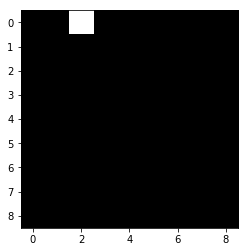

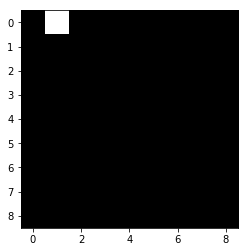

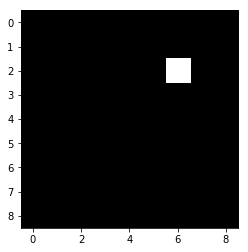

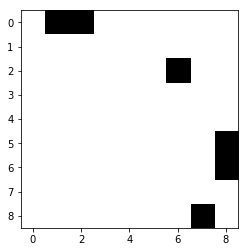

In [8]:
for file in glob.glob(games_combined_path):
    print(file)
    
    f = open(file, 'rb')
    g = CapnpGame_capnp.Game.from_bytes_packed(f.read())
    b = np.array(g.stateprobs[len(g.stateprobs)-1].state).reshape((4 + 8 , 9, 9))
    print(len(g.stateprobs),g.result)

    for i in range(12):
        plt.imshow(b[i], cmap=plt.cm.gray)            
        plt.show()
    break

In [9]:
#Selected games for test set
inputs_t = []
probs_t = []
winners_t = []

# Selected games for validation set
inputs_v = []
probs_v = []
winners_v = []

val_prob = 0.05

for file in glob.glob(games_combined_path):
    f = open(file, 'rb')
    g = CapnpGame_capnp.Game.from_bytes_packed(f.read())
    
    if np.random.sample(1)[0] > val_prob:
        inputs, probs, winners = inputs_t, probs_t, winners_t
    else:
        inputs, probs, winners = inputs_v, probs_v, winners_v
        
    for i in range(len(g.stateprobs)):
        inputs.append(np.array(g.stateprobs[i].state).reshape((4 + 8 , 9, 9)))
        probs.append(np.array(g.stateprobs[i].probs))
        winners.append(g.result)

In [10]:
inputs_t = np.array(inputs_t)
probs_t = np.array(probs_t)
winners_t = np.array(winners_t)

inputs_v = np.array(inputs_v)
probs_v = np.array(probs_v)
winners_v = np.array(winners_v)

In [11]:
p = np.random.permutation(len(inputs_t))

inputs_t = inputs_t[p]
probs_t = probs_t[p]
winners_t = winners_t[p]

In [12]:
labels_t = np.concatenate((probs_t, winners_t[:, None]), axis=1)
labels_v = np.concatenate((probs_v, winners_v[:, None]), axis=1)

In [13]:
del probs_t
del probs_v
del winners_t
del winners_v

In [14]:
inputs_t.shape, labels_t.shape

((955905, 12, 9, 9), (955905, 83))

In [15]:
inputs_v.shape, labels_v.shape

((50737, 12, 9, 9), (50737, 83))

In [16]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import sys

In [17]:
ctx = mx.cpu()
batch_size = 128

diter = mx.io.NDArrayIter(inputs_t, labels_t, batch_size=batch_size, last_batch_handle='roll_over')
val_set_x = mx.nd.array(inputs_v).as_in_context(mx.cpu())
val_set_y = mx.nd.array(labels_v).as_in_context(mx.cpu())

In [18]:
def _conv3x3(channels, stride, in_channels, kernel_size, groups, padding):
    return gluon.nn.Conv2D(channels, kernel_size=kernel_size, strides=stride, padding=padding,
                     use_bias=False, in_channels=in_channels, groups=groups)

class BasicBlockV2(gluon.HybridBlock):
    def __init__(self, channels, stride=1, in_channels=0, **kwargs):
        super(BasicBlockV2, self).__init__(**kwargs)
        self.convs = gluon.nn.HybridSequential()
        self.convs.add(gluon.nn.BatchNorm())
        self.convs.add(gluon.nn.LeakyReLU(alpha=0.3))
        self.convs.add(_conv3x3(channels, stride, in_channels, 3, 1, 1))
        self.convs.add(gluon.nn.BatchNorm())
        self.convs.add(gluon.nn.LeakyReLU(alpha=0.3))
        self.convs.add(_conv3x3(channels, 1, channels, 3, 1, 1))

    def hybrid_forward(self, F, x):
        residual = x
        x = self.convs(x)
        return x + residual

class CombinedNet(gluon.HybridBlock):
    def __init__(self, num_filters, num_blocks, **kwargs):
        super(CombinedNet, self).__init__(**kwargs)

        with self.name_scope():
            self.convs = gluon.nn.HybridSequential()
            self.convs.add(gluon.nn.Conv2D(num_filters, 3, padding=1))
            self.convs.add(gluon.nn.LeakyReLU(alpha=0.3))

            for _ in range(num_blocks):
                self.convs.add(BasicBlockV2(num_filters))

            self.convs.add(gluon.nn.Conv2D(num_filters, 3, padding=1))
            self.convs.add(gluon.nn.LeakyReLU(alpha=0.3))

            self.value = gluon.nn.HybridSequential()
            self.value.add(gluon.nn.Conv2D(2, 3, padding=1))
            self.value.add(gluon.nn.LeakyReLU(alpha=0.3))
            self.value.add(gluon.nn.Flatten())
            self.value.add(gluon.nn.Dense(num_filters))
            self.value.add(gluon.nn.LeakyReLU(alpha=0.3))
            self.value.add(gluon.nn.Dense(1))

            self.policy = gluon.nn.HybridSequential()
            self.policy.add(gluon.nn.Conv2D(2, 3, padding=1))
            self.policy.add(gluon.nn.LeakyReLU(alpha=0.3))
            self.policy.add(gluon.nn.Flatten())
            self.policy.add(gluon.nn.Dense((9 * 9 + 1) * 2))
            self.policy.add(gluon.nn.LeakyReLU(alpha=0.3))
            self.policy.add(gluon.nn.Dense(9 * 9 + 1))

    def hybrid_forward(self, F, x):
        x = self.convs(x)
        p = self.policy(x)
        v = self.value(x)

        return F.softmax(p), F.sigmoid(v), p, v

In [19]:
net = CombinedNet(64, 3)
net.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
net.hybridize()

policy_loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)
policy_loss.hybridize()

value_loss = gluon.loss.SigmoidBCELoss()
value_loss.hybridize()

In [20]:
trainer = gluon.Trainer(net.collect_params(), 'NAG', {'learning_rate': .1, 'momentum': .9, 'wd': 1e-4})

def rmean(series, win=1000):
    return np.mean(series[-win:])

In [21]:
closses = []
vlosses = []
plosses = []
vaccs = []
paccs = []

val_closses = []
val_vlosses = []
val_plosses = []

In [22]:
def pred_val_set(x,y):
    # Predict Validation set and append losses
    py = y[:, :(9*9+1)]
    vy = y[:, (9*9+1)]

    _,_,pp,vp = net(x)
    vloss = value_loss(vp, vy)
    ploss = policy_loss(pp, py)  
    closs = (0.1 * vloss.mean() + ploss.mean())

    val_closses.append(closs.as_in_context(mx.cpu()).asnumpy()[0])
    val_vlosses.append(vloss.as_in_context(mx.cpu()).asnumpy()[0])
    val_plosses.append(ploss.as_in_context(mx.cpu()).asnumpy()[0])

In [23]:
def wrap_iter(it):
    while True:
        try:
            yield it.next()
        except StopIteration:
            pred_val_set(val_set_x,val_set_y)
            
            it.reset()

In [24]:
def early_stopping(last = 3):
    if len(val_closses) >= 3:
        return val_closses[-3]<val_closses[-2] and val_closses[-2]<val_closses[-1]
    return False

In [25]:
def random_augmentation(x,y):
    for i in range(x.shape[0]):
        seed = np.random.randint(low=0, high=2, size=3, dtype=int)
        y_probs = y[i,:(9*9+1)].reshape((9, 9))
        if seed[0]:
            x[i] = nd.transpose(x[i], (0, 2, 1))
            y_probs[i] = nd.transpose(y_probs[i])
        if seed[1]:
            x[i] = nd.flip(x[i], 1)
            y_probs[i] = nd.flip(y_probs[i], 1)
        if seed[2]:
            x[i] = nd.flip(x[i], 2)
            y_probs[i] = nd.flip(y_probs[i], 2)
        y_probs = y[i,:-1].flatten()
        y[i] = np.concatenate((y_probs, y[i, (9*9+1)]), axis=0)
        print(x,y)
    return x,y

In [26]:
sigmoid = gluon.nn.Activation('sigmoid')

In [27]:
pred_val_set(val_set_x,val_set_y)

In [2]:
for i, batch in enumerate(wrap_iter(diter)):
    x = batch.data[0].as_in_context(ctx)
    y = batch.label[0].as_in_context(ctx)
    x,y = random_augmentation(x,y)
    
    py = y[:, :(9*9+1)]
    vy = y[:, (9*9+1)]

    with autograd.record():
        _, _, pp, vp = net(x)
        vloss = value_loss(vp, vy)
        ploss = policy_loss(pp, py)

        combined_loss = (0.1 * vloss.mean() + ploss.mean())
        combined_loss.backward()

    closses.append(combined_loss.as_in_context(mx.cpu()).asnumpy()[0])
    vlosses.append(vloss.as_in_context(mx.cpu()).asnumpy()[0])
    plosses.append(ploss.as_in_context(mx.cpu()).asnumpy()[0])
    paccs.append((pp.argmax(axis=-1) == py.argmax(axis=-1)).mean().as_in_context(mx.cpu()).asnumpy()[0] * 100)
    vaccs.append(((sigmoid(vp) > .5).flatten()[:, 0] == vy).mean().as_in_context(mx.cpu()).asnumpy()[0] * 100)

    trainer.step(batch_size)

    sys.stdout.write('\r{}: C:{:.3f}, V:{:.3f} ({:.1f}%), P:{:.3f} ({:.1f}%), ValC {:.3f}'.format(
        i, rmean(closses), rmean(vlosses), rmean(vaccs), rmean(plosses), rmean(paccs),val_closses[-1]))

    if early_stopping() or i == 1000000:
        print("Training stopped")
        break

NameError: name 'wrap_iter' is not defined

In [ ]:
np.mean(paccs[-1000:])

In [56]:
np.mean(vaccs[-1000:])

/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/SWP35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/valentinwolf/Documents/Studium/Machine_Learning/SoftwareProjekt/SWP35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [24]:
net.export('/home/ben/go-swp/networks/agz_small_9x9')